In [7]:
import numpy as np
import csv
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib

import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset_odn = datasets.C100Dataset('./dataset/data/cifar100.csv')
[tr_x, tr_y, ts_x, ts_y] = dataset_odn.getDataset()

In [3]:
len(tr_x), len(ts_x), len(set(tr_y))

(50000, 10000, 100)

turtle


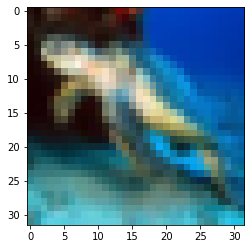

In [4]:
im_dir = './dataset/'
plt.imshow(img.imread(im_dir+tr_x[99]))
print(tr_y[99])

In [5]:
label = set(tr_y)
label = np.array(list(label))
label

array(['rocket', 'bee', 'lizard', 'castle', 'tractor', 'shrew', 'lion',
       'hamster', 'house', 'forest', 'shark', 'leopard', 'mountain',
       'pear', 'caterpillar', 'butterfly', 'sea', 'orchid', 'bowl',
       'worm', 'rabbit', 'couch', 'cloud', 'dolphin', 'porcupine', 'cup',
       'snake', 'camel', 'train', 'aquarium_fish', 'beaver', 'lawn_mower',
       'palm_tree', 'bicycle', 'apple', 'possum', 'otter', 'tank',
       'crocodile', 'clock', 'turtle', 'streetcar', 'skyscraper',
       'flatfish', 'fox', 'dinosaur', 'willow_tree', 'elephant',
       'pine_tree', 'poppy', 'mushroom', 'wardrobe', 'man', 'squirrel',
       'seal', 'beetle', 'cockroach', 'motorcycle', 'maple_tree',
       'television', 'skunk', 'cattle', 'bed', 'oak_tree', 'sunflower',
       'bottle', 'trout', 'road', 'mouse', 'chimpanzee', 'whale', 'woman',
       'spider', 'pickup_truck', 'crab', 'chair', 'keyboard', 'snail',
       'kangaroo', 'girl', 'wolf', 'bear', 'table', 'sweet_pepper',
       'plate', 'boy

In [8]:
trainx = np.array([img.imread(im_dir+u).T.reshape([-1]).T for i,u in enumerate(tr_x)])
trainy = np.zeros([len(tr_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(tr_y):
        if v==u: trainy[j][i] = 1
            
testx = np.array([img.imread(im_dir+u).T.reshape([-1]).T for i,u in enumerate(ts_x)])
testy = np.zeros([len(ts_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(ts_y):
        if v==u: testy[j][i] = 1
trainx, testx = torch.FloatTensor(trainx), torch.FloatTensor(testx)
trainy, testy = torch.FloatTensor(trainy), torch.FloatTensor(testy)

In [9]:
def tr_val(x_, y_):
    mask = np.ones(len(x_))
    mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    y_tr, y_vl = y_[mask==1], y_[mask==0]
    return x_tr, x_vl, y_tr, y_vl
def batch_div(x_, y_, num):
    x_b, y_b = [], []
    mask = np.tile(np.arange(int(len(x_)/num)), num)
    np.random.shuffle(mask)
    for i in range (int(len(x_)/num)):
        x_b.append(x_[mask==i])
        y_b.append(y_[mask==i])
    return int(len(x_)/num), x_b, y_b

# fully connected NN with softmax
class Net(nn.Module):
    def __init__(self, node = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(3*32*32, self.node)
        self.W2 = nn.Linear(self.node, self.node)
        self.W3 = nn.Linear(self.node, 100)
        self.activ = nn.ReLU()
        self.S = nn.Softmax()
        
        
        #nn.init.xavier_normal_(self.W1.weight)
        #nn.init.xavier_normal_(self.W2.weight)
        #nn.init.xavier_normal_(self.W3.weight)
        nn.init.kaiming_normal_(self.W1.weight)
        nn.init.kaiming_normal_(self.W2.weight)
        nn.init.kaiming_normal_(self.W3.weight)
        
    def forward(self, x):
        x = self.activ(self.W1(x))
        x = self.activ(self.W2(x))
        x = self.S(self.W3(x))
        return x
    def loss1(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y)+regular
    def loss2(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y)+regular
    def accuracy(self, output, y):
        return torch.sum(torch.argmax(output, axis=1)==torch.argmax(y, axis=1))

In [24]:
reg = 0
model = Net(node = 200)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 100
x_tr, x_vl, y_tr, y_vl = tr_val(trainx, trainy)
tr_loss, vl_loss = np.zeros(n_epochs, dtype='float64'), np.zeros(n_epochs, dtype='float64')
tr_accy, ts_accy = np.zeros_like(tr_loss), np.zeros_like(tr_loss)

for epoch in range(n_epochs):
    losst = 0.
    batchnum, x_tr_b, y_tr_b = batch_div(x_tr, y_tr, 100)
    for i in range (batchnum):
        loss = model.loss2(model.forward(x_tr_b[i]), y_tr_b[i], reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losst += loss.item()
    lossv = model.loss2(model.forward(x_vl), y_vl, reg)
    
    
    tr_loss[epoch] = losst
    vl_loss[epoch] = lossv.item()
    tr_accy[epoch] = model.accuracy(model.forward(x_tr), y_tr)
    ts_accy[epoch] = model.accuracy(model.forward(testx), testy)
    
    print("epoch:", epoch, "*test loss:", losst, "*val loss:", lossv.item(), "*tr/ts accuracy:", tr_accy[epoch], ts_accy[epoch])

<ipython-input-9-7cc53f398866>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.S(self.W3(x))


epoch: 0 *test loss: 20.66668562218547 *val loss: 0.048973698168992996 *tr/ts accuracy: 3986.0 964.0
epoch: 1 *test loss: 19.033300153911114 *val loss: 0.04749603942036629 *tr/ts accuracy: 5206.0 1234.0
epoch: 2 *test loss: 18.37829155102372 *val loss: 0.04641428217291832 *tr/ts accuracy: 6259.0 1485.0
epoch: 3 *test loss: 17.904881488531828 *val loss: 0.04509258270263672 *tr/ts accuracy: 7335.0 1672.0
epoch: 4 *test loss: 17.572665072977543 *val loss: 0.04464477300643921 *tr/ts accuracy: 7860.0 1781.0
epoch: 5 *test loss: 17.312710389494896 *val loss: 0.044011786580085754 *tr/ts accuracy: 8574.0 1939.0
epoch: 6 *test loss: 17.024500593543053 *val loss: 0.04386451467871666 *tr/ts accuracy: 8753.0 1929.0
epoch: 7 *test loss: 16.83500163629651 *val loss: 0.04381662607192993 *tr/ts accuracy: 8945.0 1958.0
epoch: 8 *test loss: 16.64981161803007 *val loss: 0.043389689177274704 *tr/ts accuracy: 9445.0 1984.0
epoch: 9 *test loss: 16.480534806847572 *val loss: 0.04383189231157303 *tr/ts accura

epoch: 80 *test loss: 13.39830294251442 *val loss: 0.046361375600099564 *tr/ts accuracy: 15576.0 2201.0
epoch: 81 *test loss: 13.353673020377755 *val loss: 0.04678637161850929 *tr/ts accuracy: 15077.0 2175.0
epoch: 82 *test loss: 13.353079725056887 *val loss: 0.04668975993990898 *tr/ts accuracy: 15551.0 2221.0
epoch: 83 *test loss: 13.3614605627954 *val loss: 0.047276370227336884 *tr/ts accuracy: 15222.0 2146.0
epoch: 84 *test loss: 13.333901965990663 *val loss: 0.046924639493227005 *tr/ts accuracy: 15512.0 2201.0
epoch: 85 *test loss: 13.309759821742773 *val loss: 0.04684238135814667 *tr/ts accuracy: 15683.0 2217.0
epoch: 86 *test loss: 13.30213681422174 *val loss: 0.04724452272057533 *tr/ts accuracy: 15402.0 2151.0
epoch: 87 *test loss: 13.227843457832932 *val loss: 0.04767005518078804 *tr/ts accuracy: 15097.0 2136.0
epoch: 88 *test loss: 13.253053739666939 *val loss: 0.047375477850437164 *tr/ts accuracy: 15643.0 2112.0
epoch: 89 *test loss: 13.294598186388612 *val loss: 0.0473399460

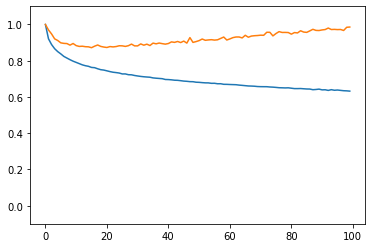

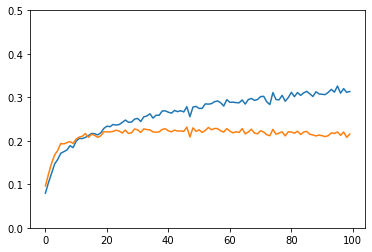

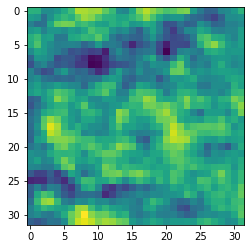

In [25]:
plt.plot(tr_loss/np.max(tr_loss))
plt.plot(vl_loss/np.max(vl_loss))
plt.ylim(-0.1, 1.1)
plt.show()
plt.plot(tr_accy/50000)
plt.plot(ts_accy/10000)
plt.ylim(0, 0.5)
plt.show()

plt.imshow(np.array(model.W1.weight.data[0][:1024]).reshape([32, 32]))

In [26]:
def pred_img(num):
    im_dir = './dataset/'
    plt.imshow(img.imread(im_dir+ts_x[num]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T.reshape([-1]).T for i,u in enumerate(ts_x[num:num+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[num]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])
    
def correct_img(num):
    correct_ind = []
    im_dir = './dataset/'
    for i in range (10000):
        test_x = np.array([img.imread(im_dir+u).T.reshape([-1]).T for j,u in enumerate(ts_x[i:i+1])])
        test_x = torch.FloatTensor(test_x)
        test_y = ts_y[i]
        output = model.forward(test_x)
        if torch.argmax(output, axis=1)==torch.argmax(testy[i]):
            correct_ind.append(i)
    return correct_ind
             
correct_ind = correct_img(10)

<ipython-input-9-7cc53f398866>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.S(self.W3(x))


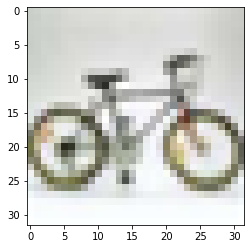

<ipython-input-9-7cc53f398866>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.S(self.W3(x))


real: bicycle pred: bicycle


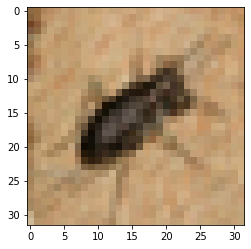

real: beetle pred: beetle


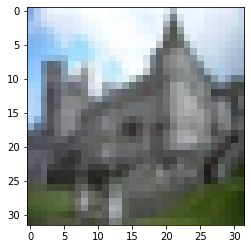

real: castle pred: castle


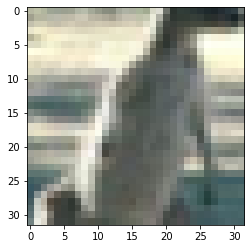

real: kangaroo pred: kangaroo


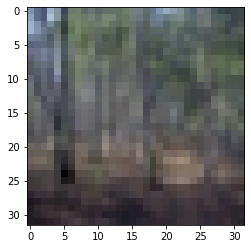

real: forest pred: forest


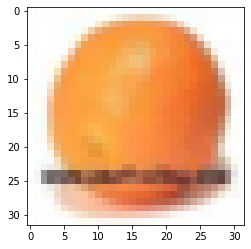

real: orange pred: orange


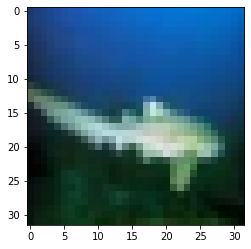

real: shark pred: shark


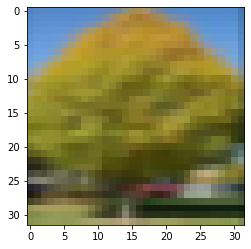

real: maple_tree pred: maple_tree


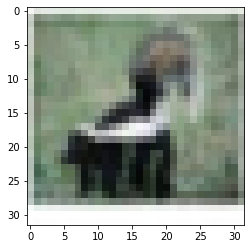

real: skunk pred: skunk


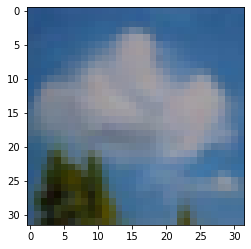

real: cloud pred: cloud


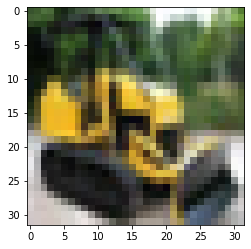

real: tractor pred: tractor


In [27]:
n=0
num=10
np.random.shuffle(correct_ind)
for i in correct_ind:
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T.reshape([-1]).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])
    n+=1
    if n>num: break